In [2]:
''' Import libraries '''
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn import datasets
import numpy as np

In [24]:
''' Load data '''
file_path = "Heart_Disease_Prediction.csv" # Make sure to change this
df_all = pd.read_csv(file_path).drop(["index"], axis=1)
df = df_all.drop("Heart Disease", axis=1) # DataFrame containing the dataset without the target variable
df_target = df_all["Heart Disease"]       # DataFrame containing only the target variable
df.head(10)

270


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3
5,65,1,4,120,177,0,0,140,0,0.4,1,0,7
6,56,1,3,130,256,1,2,142,1,0.6,2,1,6
7,59,1,4,110,239,0,2,142,1,1.2,2,1,7
8,60,1,4,140,293,0,2,170,0,1.2,2,2,7
9,63,0,4,150,407,0,2,154,0,4.0,2,3,7


In [4]:
''' Show basic statistical data for each column '''
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


Text(0, 0.5, 'Percentage')

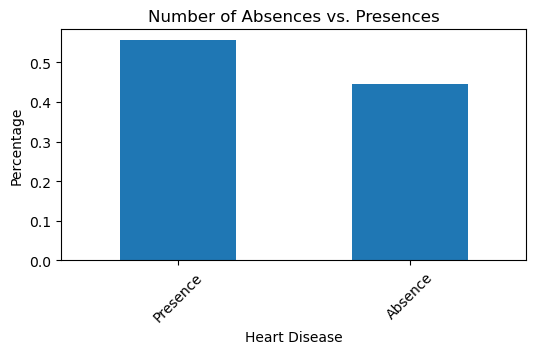

In [5]:
''' Show bar graph for target variable (heart disease) '''
ax = df_target.value_counts(normalize=True).plot(kind='bar')
fig = ax.get_figure()
fig.set_size_inches(6,3)

ax.set_title("Number of Absences vs. Presences")
ax.set_xlabel("Heart Disease"); ax.set_xticklabels(df_target.unique(), rotation=45)
ax.set_ylabel("Percentage")

**Kurtosis** – Measure of how heavy-tailed/light-tailed the data is compared to normal distribution
- Mesokurtic (kurt ~= 3): tails similar to Gaussian
- Platykurtic (kurt < 3): thinner tail, shorter distribution; low presence of extreme values
- Leptokurtic (kurt > 3): thicker tail, longer distribution; extreme values present

**Skewness** – Measure of symmetry
- Left-skewed (skew < -0.5): tail is on left of mean; majority of data on right; outliers on right
- Right-skewed/positively-skewed (skew > 0.5): tail is on right of mean; majority of data on left; outliers on left
- Symmetric (-0.5 < skew < 0.5): left and right sides are mirrors of each other

In [6]:
''' Calculate measures of spread for each non-target column '''
df_spread = pd.DataFrame(columns=["kurtosis", "skewness"], index=df.columns)
for feature in df_spread.index.values:
    df_spread.loc[feature, "kurtosis"] = df[feature].kurt()
    df_spread.loc[feature, "skewness"] = df[feature].skew()
    
df_spread

,kurtosis,skewness
Age,-0.544815,-0.163615
Sex,-1.425259,-0.765084
Chest pain type,-0.296548,-0.878767
BP,0.923097,0.722618
Cholesterol,4.895599,1.183721
FBS over 120,1.982578,1.991971
EKG results,-2.005358,-0.044703
Max HR,-0.103072,-0.527737
Exercise angina,-1.479699,0.728915
ST depression,1.759317,1.262893


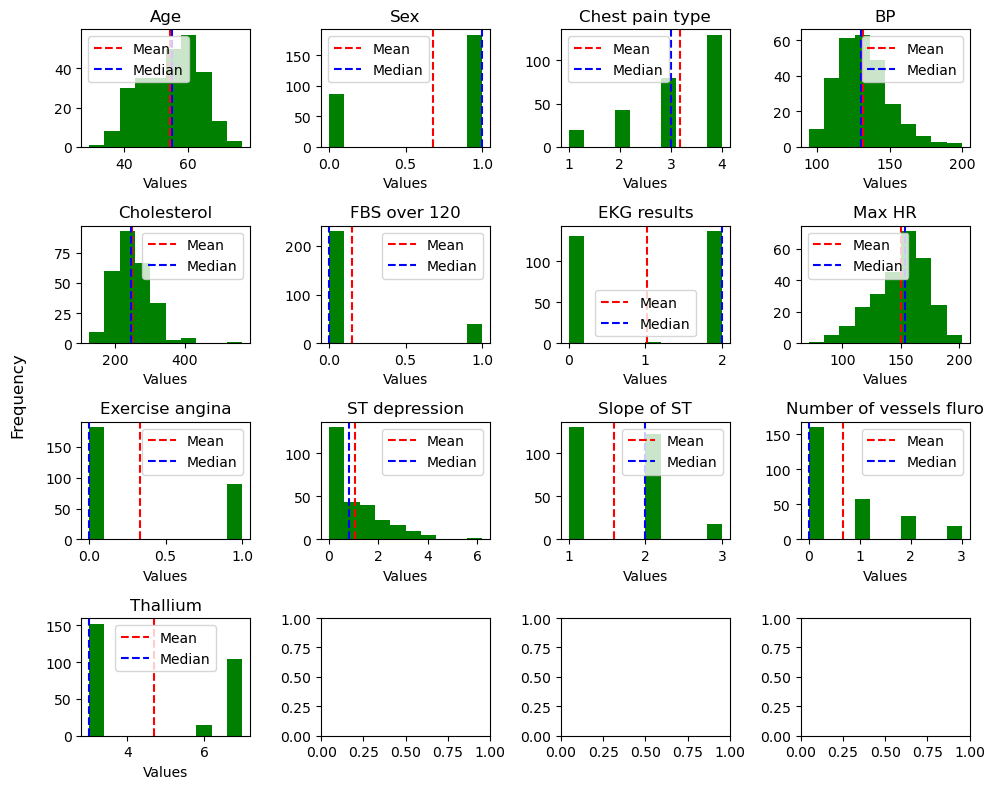

In [7]:
''' Plot histograms for each non-target variable '''
fig, axs = plt.subplots(4,4, figsize=[10,8], tight_layout=True)
fig.supylabel("Frequency", x=0.01)

for row_num, ax_row in enumerate(axs):
    for col_num, ax_col in enumerate(axs[row_num]):
        feat_idx = (4 * row_num) + col_num
        if feat_idx < len(df.columns):
            ax = axs[row_num][col_num]
            ax.hist(df.iloc[:, feat_idx], color='green')
            ax.axvline(x=df.iloc[:, feat_idx].mean(), linestyle='--', color='r', label='Mean')
            ax.axvline(x=df.iloc[:, feat_idx].median(), linestyle='--', color='b', label='Median')
            
            ax.set_title(df.columns[feat_idx])
            ax.set_xlabel("Values")
            ax.legend()
            ax.legend()

In [8]:
''' Show medians for each feature '''
df_all.median()

C:\Users\Felipe\AppData\Local\Temp\ipykernel_5092\2539385771.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_all.median()


Age                         55.0
Sex                          1.0
Chest pain type              3.0
BP                         130.0
Cholesterol                245.0
FBS over 120                 0.0
EKG results                  2.0
Max HR                     153.5
Exercise angina              0.0
ST depression                0.8
Slope of ST                  2.0
Number of vessels fluro      0.0
Thallium                     3.0
dtype: float64

TypeError: boxplot() got an unexpected keyword argument 'sharex'

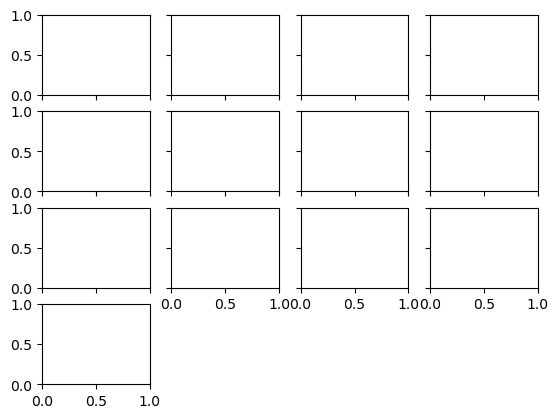

In [9]:
''' Create boxplots for each feature, grouped by the target variable '''
axs_box = df_all.boxplot(by=df_all.columns[-1], return_type='axes', sharex=False, sharey=False)
fig_box = axs_box[0].get_figure()
fig_box.set_size_inches([10, 8])
fig_box.tight_layout()
fig_box.supylabel("")

In [10]:
''' Manually encode target variable as 1 for Presence and 0 for Absence'''
target_vals = df_all.iloc[:,-1].to_numpy()
for count, val in enumerate(target_vals):
    if val == "Presence":
        target_vals[count] = 1
    elif val == "Absence":
        target_vals[count] = 0
df_all.iloc[:,-1] = target_vals
df_all.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [11]:
''' Create heatmap '''
corrmat = df_all.corr(numeric_only=False)
ax_hm = sns.heatmap(data=corrmat, annot=True, square=True,
                    xticklabels=df_all.columns, yticklabels=df_all.columns, cmap="Spectral_r")
fig_hm = ax_hm.get_figure()
fig_hm.set_size_inches([10,10])

TypeError: corr() got an unexpected keyword argument 'numeric_only'

In [12]:
file_path = "Heart_Disease_Prediction.csv" # Make sure to change this
df_LDA = pd.read_csv(file_path).drop(["index"], axis = 1)
target_variable = df_LDA['Heart Disease']
df_LDA = df_LDA.drop(['BP', 'Cholesterol', 'FBS over 120', 'EKG results','Heart Disease'], axis = 1)
print(df_LDA)

     Age  Sex  Chest pain type  Max HR  Exercise angina  ST depression  \
0     70    1                4     109                0            2.4   
1     67    0                3     160                0            1.6   
2     57    1                2     141                0            0.3   
3     64    1                4     105                1            0.2   
4     74    0                2     121                1            0.2   
..   ...  ...              ...     ...              ...            ...   
265   52    1                3     162                0            0.5   
266   44    1                2     173                0            0.0   
267   56    0                2     153                0            1.3   
268   57    1                4     148                0            0.4   
269   67    1                4     108                1            1.5   

     Slope of ST  Number of vessels fluro  Thallium  
0              2                        3         3  
1  

In [60]:
n_col = len(df_LDA)
n_feat = len(df_LDA.columns)

X = df_LDA
y = target_variable

In [61]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X, target_variable)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lda, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))

0.8444444444444443


In [62]:
array = []
for x in range(len(y)):
    if(y[x] == "Absence"):
        array.append(0)
    else:
        array.append(1)

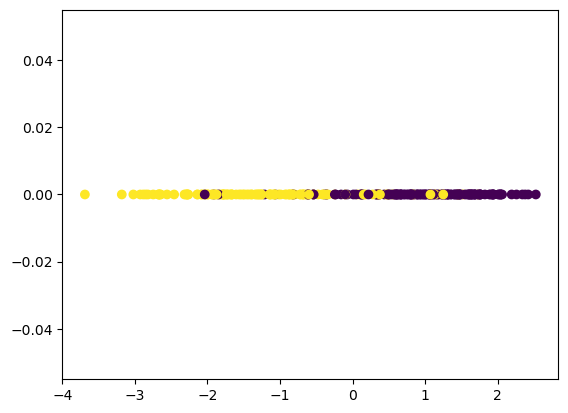

In [63]:
X_lda = lda.fit_transform(X, y)
plt.scatter(X_lda[:, 0], np.zeros_like(X_lda[:, 0]), c=array)
plt.show()